In [1]:

import os, math
from scipy.interpolate import splprep, splev
import numpy as np
from matplotlib import pyplot as plt 
from Spline import AKBSpline

try:
    data_path = os.environ['data']
except KeyError:
    data_path = './data/'



In [2]:
from hdf5_to_dict import load_hdr, load_geom, load_dump, load_tracer, grid_matrix_multiply

fname = os.path.join(data_path,'tracer/dump_00001000.h5')
fname_tracer = os.path.join(data_path,'tracer/torus_gw170817_traces_pruned_r250/tracers_00000015.h5part')
hdr = load_hdr(fname)
geom  = load_geom(hdr)
tracer = load_tracer(fname_tracer)


In [13]:
geom.keys()

dict_keys(['gcov', 'gcon', 'gdet', 'alpha', 'X1', 'X2', 'X3', 'x', 'y', 'z', 'X1f', 'X2f', 'X3f', 'xf', 'yf', 'zf', 'Lambda_h2cart_con', 'Lambda_h2cart_cov', 'r', 'th', 'phi', 'rcyl', 'Lambda_h2bl_con', 'Lambda_h2bl_cov', 'Lambda_bl2cart_con', 'Lambda_bl2cart_cov', 'Lambda_h2bl_con_3d', 'Lambda_h2bl_cov_3d', 'Gamma'])

In [2]:

tra = np.load('trajectories.npy')
min_coord = np.array([   0. ,        0.,         0. ,     -999.64136, -999.7137,  -997.5717 ], dtype=np.float32)[None,None,:]
max_coord = np.array([6.9077554e+00, 9.9213535e-01, 6.2831855e+00, 9.9986377e+02, 9.9980994e+02, 9.9779254e+02], dtype=np.float32)[None,None,:]
#normalization
tra = (tra - min_coord) / (max_coord - min_coord)
length = np.load('tra_len.npy')

In [4]:
def fit_spline(trace, length):
    trace = trace[:length,3:]
    k = 3
    n_knots = 100
    # t_input = [0.0] * k + np.linspace(0,0.1,(n_knots - 2*k)//2).tolist() + np.linspace(0.11, 1, (n_knots- 2*k)//2).tolist() + [1.0] * k
    # t_input = [0.0] * k + np.linspace(0,1,n_knots - 2*k).tolist() + [1.0] * k
    # tcku, fp, ier, msg = splprep(trace.T, t=t_input, k = k, task=-1, full_output=True, quiet=True)
    spline = AKBSpline(trace, n_knots, k)
    tcku = spline.tcku
    fp = spline.fp
    tck, u = tcku
    return fp/length, tck, u


In [5]:
spline = list(map(fit_spline,tra,length))
# for i, (fp, tck, u) in enumerate(map(fit_spline,tra,length)):
#     print(i)


5.040144182800662e-09
96
8.62337592166367e-09
96
8.829673324509114e-09
96


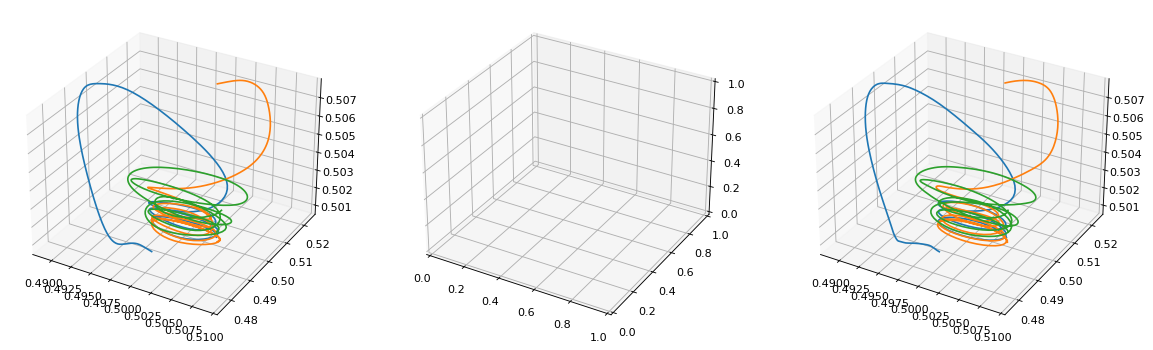

In [7]:
recon = np.load('output_spline.npy')
fig = plt.figure(figsize=(18, 10), dpi=80)
ax = fig.add_subplot(1,3,1,projection='3d')
ax2 = fig.add_subplot(1,3,2,projection='3d')
ax3 = fig.add_subplot(1,3,3,projection='3d')

for i in range(1000,1003):
    l = 250

    phi = np.linspace(0, 2*np.pi, l)
    x = np.sin(phi)
    y = np.cos(phi)
    rgb_cycle = np.vstack((            # Three sinusoids
        .5*(1.+np.cos(phi          )), # scaled to [0,1]
        .5*(1.+np.cos(phi+2*np.pi/3)), # 120° phase shifted.
        .5*(1.+np.cos(phi-2*np.pi/3)))).T # Shape = (60,3)

    err, tck, u = spline[i]
    print(err)
    t,c,k = tck
    print(len(c[0]))
    new_points = splev(u, tck)
    # ax.scatter(new_points[0][:l], new_points[1][:l], new_points[2][:l], '.',c=rgb_cycle)
    ax.plot(new_points[0][:l],new_points[1][:l],new_points[2][:l])

    # new_c = recon[i].T
    # error = ((new_c - np.array(c)) ** 2).mean()
    # new_tck = [t,new_c,k]
    # print(error)
    
    # new_points = splev(u, new_tck)
    # # ax2.scatter(new_points[0][:l], new_points[1][:l], new_points[2][:l], '.',c=rgb_cycle)
    # ax2.plot(new_points[0][:l],new_points[1][:l],new_points[2][:l])

    trace = tra[i,:length[i],3:]
    # ax3.scatter(trace[:l,0], trace[:l,1], trace[:l,2], 'o',c=rgb_cycle)
    ax3.plot(trace[:l,0], trace[:l,1], trace[:l,2])


In [5]:
#prepare training
data = np.zeros((len(tra),96+1,3),dtype=np.float32)
for i, trace in enumerate(tra):
    start_particle = trace[0,3:]
    c = np.array(spline[i][1][1]).T
    d = np.concatenate([start_particle[None,:],c],axis=0)
    data[i] = d
np.save('spline_training.npy',data)
    
    

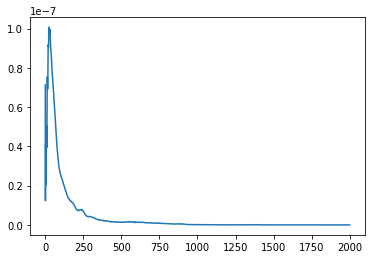

In [6]:
error, tck, u = zip(*spline)
ave_e = np.zeros((length.max()))
mask = np.zeros((length.max()),dtype=int)
for i,uu in enumerate(u):
    new_points = splev(uu, tck[i])
    new_points = np.array(new_points)
    trace = tra[i,:length[i],3:]
    e = ((new_points.T - trace) ** 2).sum(1)
    ave_e[:len(e)] += e
    mask[:len(e)] += 1
ave_e /= mask

plt.plot(np.arange(len(ave_e)),ave_e)
plt.show()
    


4.570510228068674e-09


(array([8.3248e+04, 2.0000e+01, 2.0000e+00, 1.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([2.27142916e-12, 2.37802636e-07, 4.75603000e-07, 7.13403364e-07,
        9.51203729e-07, 1.18900409e-06, 1.42680446e-06, 1.66460482e-06,
        1.90240519e-06, 2.14020555e-06, 2.37800591e-06]),
 <BarContainer object of 10 artists>)

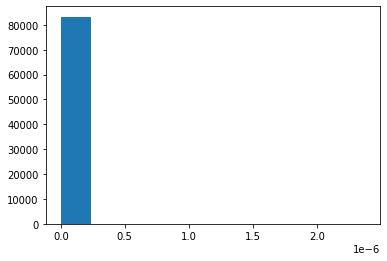

In [7]:
error = np.array(error)
print(np.mean(error))
plt.hist(error)

In [6]:
from stats import Stat
dims = [8,8,4]
stat = Stat(dims,fname,True)
stat.sample_at_particles()
print(stat.error.min(),stat.error.max())
stat.error[stat.error > 10] = 0
stat.error[stat.error < -10] = 0
print(stat.error.min(),stat.error.max())
mse = (stat.error ** 2).mean()
10 * math.log10(0.07457909845/mse)

[[ 0.          0.          0.         -0.00186098]
 [ 0.          0.          0.         -0.01638369]
 [ 0.          0.          0.         -0.02147934]
 ...
 [ 0.          0.          0.          0.00297379]
 [ 0.          0.          0.         -0.02263373]
 [ 0.          0.          0.         -0.0015574 ]]
-0.1430792985717403 0.14453976380933017
0.0001102728065950806
28.301487009760834
